In [540]:
import os
import imageio
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import visvis as vv

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier



In [2]:
letterDict={
  "a": 0,"b": 1,"c": 2,"d": 3,"e": 4,"f": 5,"g": 6,"h": 7,"i": 8,
    "j": 9,"k": 10,"l": 11,"m": 12,"n": 13,"o": 14,"p": 15,"q": 16,"r": 17,
    "s": 18,"t": 19,"u": 20,"v": 21,"w": 22,"x": 23,"y": 24,"z": 25}

numberDict={
    0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H", 8:"I",
    9:"J", 10:"K", 11:"L", 12:"M", 13:"N", 14:"O", 15:"P", 16:"Q", 17:"R",
    18:"S", 19:"T", 20:"U", 21:"V", 22:"W", 23:"X", 24:"Y", 25:"Z"}


def readPicture(df_complete, directory,letter_value):
    im = imageio.imread(directory)
    im.shape
    print("Letter value: ", directory, end="\r")

    im=np.reshape(im,400)
    df = pd.DataFrame(data=im).T
    y = np.repeat(0,400)
    df['Letter'] = letter_value
    
    return df_complete.append(df, ignore_index=True)

#Method ment for adding augmented pictures to a dataset
def addPictureToDataset(dataset, picture, letter_value):
    picture = np.reshape(picture,400)
    df = pd.DataFrame(data=picture).T
    df['Letter'] = letter_value
    return dataset.append(df, ignore_index=True)



In [3]:
def read_all_images(upper_directory):
    number_of_images = 0
    original_imgs = pd.DataFrame()
    aug20 = pd.DataFrame()
    aug90 = pd.DataFrame()
    aug270 = pd.DataFrame()
    aug320 = pd.DataFrame()
    for subdir, dirs, files in os.walk(upper_directory):
        for file in files:
            number_of_images+=1
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + file
            if filepath.endswith(".jpg"):
                # print(filepath)
                # Rotate every image that is being loaded:
            
                x = filepath.split("/")
                rotate20 = rotate_image(filepath,x[-1],20)
                rotate90 = rotate_image(filepath,x[-1],90)
                rotate270 = rotate_image(filepath,x[-1],270)
                rotate320 = rotate_image(filepath,x[-1],320)
                                
                # The label for the data:
                letter = (x[-1][0])
                letter_val = letterDict.get(letter)
                original_imgs = readPicture(original_imgs,filepath,letter_val)
                aug20 = addPictureToDataset(aug20, rotate20, letter_val)
                aug90 = addPictureToDataset(aug90, rotate90, letter_val)
                aug270 = addPictureToDataset(aug270, rotate270, letter_val)
                aug320 = addPictureToDataset(aug320, rotate320, letter_val)
    print("image")
    # vv.imshow("./dataset3/chars74k-lite/augmented/rotated_neg_a102.jpg")
    print("number_of_images", number_of_images)
    return original_imgs, aug20, aug90, aug270, aug320


#Rotates an image, stores it in a folder and returns the rotated image
def rotate_image(image_path,ending,deg):
    out_path = "./dataset3/augmented/"
    image_to_rotate = plt.imread(image_path)
    
    # Rotating the image:
    rotated_positive = ndimage.rotate(image_to_rotate, deg, reshape=False)
   
    fullpath = os.path.join(out_path, 'rotated_'+ str(deg) + '_' + ending)
    imageio.imwrite(fullpath, rotated_positive)
    return rotated_positive
    
    
               
# Unaugmented data, no feature selection:            
original_raw, aug20, aug90, aug270, aug320 = read_all_images("./dataset3/chars74k-lite")
original_raw
               


imager value:  ./dataset3/chars74k-lite/z/z_9.jpggg./dataset3/chars74k-lite/a/a_434.jpg ./dataset3/chars74k-lite/a/a_630.jpg ./dataset3/chars74k-lite/b/b_56.jpg ./dataset3/chars74k-lite/d/d_9.jpg ./dataset3/chars74k-lite/e/e_106.jpg ./dataset3/chars74k-lite/e/e_33.jpg ./dataset3/chars74k-lite/e/e_350.jpg ./dataset3/chars74k-lite/g/g_107.jpg ./dataset3/chars74k-lite/g/g_140.jpg ./dataset3/chars74k-lite/h/h_119.jpg ./dataset3/chars74k-lite/h/h_191.jpg ./dataset3/chars74k-lite/i/i_243.jpg ./dataset3/chars74k-lite/i/i_344.jpg ./dataset3/chars74k-lite/i/i_69.jpg ./dataset3/chars74k-lite/j/j_4.jpg ./dataset3/chars74k-lite/n/n_25.jpg ./dataset3/chars74k-lite/n/n_324.jpg ./dataset3/chars74k-lite/n/n_341.jpg ./dataset3/chars74k-lite/o/o_283.jpg ./dataset3/chars74k-lite/o/o_507.jpg ./dataset3/chars74k-lite/r/r_211.jpg ./dataset3/chars74k-lite/r/r_233.jpg ./dataset3/chars74k-lite/r/r_271.jpg ./dataset3/chars74k-lite/r/r_97.jpg ./dataset3/chars74k-lite/s/s_240.jpg ./dataset3/chars74k-lite/t/t_392.

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,Letter
0,193,175,177,191,177,188,194,177,197,157,...,175,191,175,183,188,225,185,167,193,0
1,37,34,37,46,50,45,40,39,39,38,...,34,34,35,36,37,36,36,37,38,0
2,25,33,40,42,40,38,36,35,42,46,...,33,38,38,32,31,51,43,41,41,0
3,27,34,36,30,31,35,32,23,20,12,...,24,23,23,27,40,8,27,33,20,0
4,186,192,175,189,202,182,181,188,191,193,...,194,196,185,182,196,193,190,191,194,0
5,34,37,7,25,14,19,22,26,34,13,...,14,15,19,20,17,8,30,21,15,0
6,40,5,5,0,34,8,16,38,22,40,...,35,12,0,57,31,29,6,47,59,0
7,232,251,223,238,237,221,235,232,231,216,...,20,37,35,42,22,56,37,41,13,0
8,232,228,228,229,230,234,212,138,45,45,...,232,235,199,69,26,34,54,49,96,0
9,223,229,220,216,226,222,217,231,238,225,...,229,234,228,222,223,227,227,227,227,0


In [468]:
#Methood merges dataset1 with dataset2
def mergeData(dataset1, dataset2):
    return dataset1.append(dataset2, ignore_index=True)

mergedData = mergeData(original_raw, aug20)
mergedData = mergeData(mergedData, aug90)
mergedData = mergeData(mergedData, aug270)
mergedData = mergeData(mergedData, aug320)
mergedData

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,Letter
0,193,175,177,191,177,188,194,177,197,157,...,175,191,175,183,188,225,185,167,193,0
1,37,34,37,46,50,45,40,39,39,38,...,34,34,35,36,37,36,36,37,38,0
2,25,33,40,42,40,38,36,35,42,46,...,33,38,38,32,31,51,43,41,41,0
3,27,34,36,30,31,35,32,23,20,12,...,24,23,23,27,40,8,27,33,20,0
4,186,192,175,189,202,182,181,188,191,193,...,194,196,185,182,196,193,190,191,194,0
5,34,37,7,25,14,19,22,26,34,13,...,14,15,19,20,17,8,30,21,15,0
6,40,5,5,0,34,8,16,38,22,40,...,35,12,0,57,31,29,6,47,59,0
7,232,251,223,238,237,221,235,232,231,216,...,20,37,35,42,22,56,37,41,13,0
8,232,228,228,229,230,234,212,138,45,45,...,232,235,199,69,26,34,54,49,96,0
9,223,229,220,216,226,222,217,231,238,225,...,229,234,228,222,223,227,227,227,227,0


In [6]:
# splitting function:
def get_train_test_set(data):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    
    for i in range(26):
        train, test = train_test_split(data.loc[data['Letter']==i], 
                                       test_size=0.2, shuffle=True)
        
        train_set = train_set.append([train], ignore_index=True)
        test_set = test_set.append([test], ignore_index=True)
    return train_set, test_set

## Running models on the data:
### kNN (On Raw, merged, feature-treated data)


In [457]:
#### Running models on the raw data:

def calc_predictions(classifier, train):
    y_pred = []
    n = train.shape[0]
    counter = 0
    clf = classifier.fit(train.drop(labels='Letter', axis = 1), train.iloc[:,-1])
    for row in train.drop(labels='Letter', axis = 1).iterrows():
        y_pred.append(clf.predict([row[1].tolist()]))
        counter +=1
        print((counter/n)*100,"%",end="\r")
    return y_pred,clf

def test_classifier(clf, data):
    y = []
    for row in data.drop(labels='Letter', axis = 1).iterrows():
        y.append(clf.predict(([row[1].tolist()])))
    return y



In [458]:

# Raw training and test set:
train_set_raw, test_set_raw = get_train_test_set(original_raw)

#### KNN #####
neigh = KNeighborsClassifier(n_neighbors=3)
y_raw_train_pred, clf = calc_predictions(neigh,train_set_raw)

y_test_pred = test_classifier(clf, test_set_raw)



Was classified as an:  O


<function matplotlib.pyplot.show(*args, **kw)>

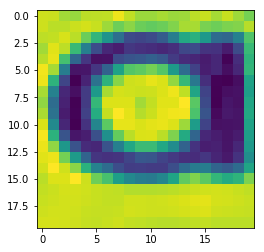

In [543]:
# Print classifications:

# kNN:
print("Was classified as an: ", numberDict.get(y_test_pred[1][0]))
test_set_raw["Letter"][1]

(test_set_raw.iloc[1,:])

a = ((test_set_raw.drop(labels='Letter', axis = 1)).loc[1].tolist())
a = np.reshape(a, (20, 20))
a

plt.imshow(a)
plt.show


In [459]:
### Running model on the augmented + raw data:

train_set_merged, test_set_merged = get_train_test_set(mergedData)

neigh = KNeighborsClassifier(n_neighbors=3)
y_merged_train_pred, clf = calc_predictions(neigh, train_set_merged)

y_merged_test_pred = test_classifier(clf, test_set_merged)


### Accuracy scores for knn


In [475]:
## Raw data:
# Train:
print("accuracy_score_knn_training_data:", accuracy_score( train_set_raw.iloc[:,-1],y_raw_train_pred))
# Test:
print("accuracy_score_knn_test_data:", accuracy_score( test_set_raw.iloc[:,-1],y_test_pred))


print(train_set_merged.iloc[:,-1].shape)

## Merged data:
# Train:
print("accuracy_score_knn_training_data:", accuracy_score( train_set_merged.iloc[:,-1],y_merged_train_pred))
# Test
print("accuracy_score_knn_test_data:", accuracy_score( test_set_merged.iloc[:,-1],y_merged_test_pred))



accuracy_score_knn_training_data: 0.8366197183098592
accuracy_score_knn_test_data: 0.6745810055865922
(28448,)
accuracy_score_knn_training_data: 0.8389693475815523
accuracy_score_knn_test_data: 0.7043025871766029


## Random Forest (On Raw, merged, feature-treated data)


In [498]:
clf_rf = RandomForestClassifier(n_estimators=200,random_state=0)

y_raw_train_pred_rf, clf_rf = calc_predictions(clf_rf,train_set_raw)

y_test_pred_rf = test_classifier(clf_rf, test_set_raw)

In [499]:
y_merged_train_pred_rf, clf = calc_predictions(clf_rf, train_set_merged)

y_merged_test_pred_rf = test_classifier(clf, test_set_merged)


### Accuracy scores for random forest

In [500]:
### Random forest accuracy:
## Raw data:
# Train:
print("accuracy_score_randomforest_training_data:", accuracy_score( train_set_raw.iloc[:,-1],y_raw_train_pred_rf))
# Test: 
print("accuracy_score_randomforest_test_data:", accuracy_score( test_set_raw.iloc[:,-1],y_test_pred_rf))


#print(train_set_merged.iloc[:,-1].shape)
## Merged data:

# Train:
print("accuracy_score_randomforest_training_data_merged:", accuracy_score( train_set_merged.iloc[:,-1],y_merged_train_pred_rf))
# Test
print("accuracy_score_randomforest_test_data_merged:", accuracy_score( test_set_merged.iloc[:,-1],y_merged_test_pred_rf))



accuracy_score_randomforest_training_data: 1.0
accuracy_score_randomforest_test_data: 0.6962290502793296
accuracy_score_randomforest_training_data_merged: 1.0
accuracy_score_randomforest_test_data_merged: 0.6511529808773904


In [ ]:
## kladd:

# cm_knn = confusion_matrix(y_test, y_pred_knn)
# plt.imshow(cm_knn, cmap='spring', interpolation='None')
# plt.show()



#print("Confusion matrix kNN:")
#print(cm_knn)
#print(" ")
#print("accuracy_score_knn:", accuracy_score(y_test,y_pred_knn))


def printLetter(letter):
    numpy_letter = letter[0:-1].values
    plt.imshow(numpy_letter.reshape(20,20), cmap = matplotlib.cm.binary)
    plt.axis("off")
    plt.title('Supposed to be {}'.format(numberDict.get(letter['Letter'])), fontsize=20)
    plt.show()
    return

a_letter = train_set.iloc[2001]
printLetter(a_letter)


# Tensorflow
### Implementation

In [496]:
import tensorflow as tf
import gzip
import pickle

def DNN(train_X,train_Y,test_X,test_y):
    # Scale data (normalization), easier for network to learn:
    # plt.imshow(train_X[0])
    # plt.show
    train_X = tf.keras.utils.normalize(train_X,axis=1)
    test_X = tf.keras.utils.normalize(test_X,axis=1)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu )) 
    model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu ))
    model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu ))
    model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu ))
    model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu ))
    model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu )) 
    model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu ))




    model.add(tf.keras.layers.Dense(26, activation = tf.nn.softmax ))

    model.compile(optimizer ='adam',
                 loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    # train:
    model.fit(train_X, train_Y, epochs = 20)
    loss, accuracy = evaluate_model(model,test_X,test_y)
    return loss, accuracy


# Helper function trained model:
def evaluate_model(model,test_X,test_y):
    val_loss, val_acc = model.evaluate(test_X, test_y)
    return val_loss, val_acc




### Running the DNN model on the data:
#### Raw data:

In [497]:
# train and test are dataframes (with the labels in the last column for both)
def transform_data_for_tensorflow_and_run(train,test):
    trainx = (train.drop(labels='Letter', axis = 1)).values
    trainy = np.array(train['Letter'].tolist())
    
    testx = (test.drop(labels='Letter', axis = 1)).values
    testy = np.array(test['Letter'].tolist())
    loss, accuracy = DNN(trainx,
           trainy,
           testx,
           testy)
    
    return loss, accuracy



# Raw set:
l1,a1 = transform_data_for_tensorflow_and_run(train_set_raw,
                                              test_set_raw)

print(" ")
print("loss on raw data:",11)
print("Accuracy on raw data: ",a1)

# Merged set
l2, a2 = transform_data_for_tensorflow_and_run(train_set_merged,
                                               test_set_merged)

print(" ")
print("loss on merged data:",12)
print("Accuracy on merged data: ",a2)


Epoch 1/20
5680/5680 [==============================] - 3s 452us/sample - loss: 3.0503 - acc: 0.0944
Epoch 2/20
5680/5680 [==============================] - 1s 260us/sample - loss: 2.7322 - acc: 0.1845
Epoch 3/20
5680/5680 [==============================] - 1s 258us/sample - loss: 2.2698 - acc: 0.3040
Epoch 4/20
5680/5680 [==============================] - 1s 253us/sample - loss: 1.9619 - acc: 0.4014
Epoch 5/20
5680/5680 [==============================] - 1s 248us/sample - loss: 1.7103 - acc: 0.4657
Epoch 6/20
5680/5680 [==============================] - 1s 248us/sample - loss: 1.5793 - acc: 0.5025s - lo
Epoch 7/20
5680/5680 [==============================] - 1s 256us/sample - loss: 1.4222 - acc: 0.5611
Epoch 8/20
5680/5680 [==============================] - 1s 250us/sample - loss: 1.3338 - acc: 0.5896
Epoch 9/20
5680/5680 [==============================] - 1s 254us/sample - loss: 1.2511 - acc: 0.6136
Epoch 10/20
5680/5680 [==============================] - 2s 300us/sample - loss: 1.13

In [ ]:
# Sort